In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import random

In [ ]:
def Gaussian_kernel(pixel1,pixel2, omega):
  return np.exp(-((pixel1[0]-pixel2[0])**2+(pixel1[1]-pixel2[1])**2)/(2*omega**2))

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 116, 111, ..., 182, 172, 208],
       [  0, 124, 113, ..., 183, 176, 211],
       ...,
       [  0, 128, 102, ..., 196, 194, 245],
       [  0, 135, 111, ..., 202, 190, 243],
       [  0, 117, 112, ..., 203, 191, 232]], dtype=uint8)
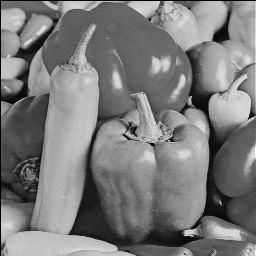

In [ ]:
vegetables = cv2.imread('/vegetables.png', cv2.IMREAD_GRAYSCALE)
ruined_img = vegetables.copy()
vegetables

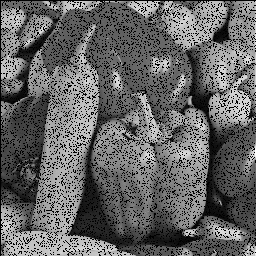

In [ ]:
ratio_of_ruined_pixels = 0.2
num_pixels_to_change = int(vegetables.shape[0] * vegetables.shape[1] * ratio_of_ruined_pixels)
coordinates_ruined = []
for _ in range(num_pixels_to_change):
    x = random.randint(0, vegetables.shape[0] - 1)
    y = random.randint(0, vegetables.shape[1] - 1)
    ruined_img[x, y] = 0
    coordinates_ruined.append((x,y))
corrected_img = ruined_img.copy()
cv2_imshow(ruined_img)

In [ ]:
def extract_p_time_p_square(tuple_point, p, omega):
  """
  Extracts p time p square around the point given by the tuple and computes the Gaussian kernel matrix that is p^2 x p^2.

  Args:
    tuple_point: A tuple representing the coordinates (x, y) of the point.
    p: The size of the square (p x p).
    omega: The value used for calculating the Gaussian kernel.

  Returns:
    - A list of tuples representing the coordinates within the p x p square
    around the given point
    - The p^2 x p^2 Gaussian kernel matrix (if the square is fully contained in the image)
    - The pixel_strength list (in the same order as the extracted pixels)
    -noised pixels
  """
  x, y = tuple_point
  extracted_points = []
  pixel_strengths =[]


  for i in range(x - p // 2, x + p // 2 + 1):
    for j in range(y - p // 2, y + p // 2 + 1):
      if 0 <= i < vegetables.shape[0] and 0 <= j < vegetables.shape[1] and (i,j) not in coordinates_ruined:
        extracted_points.append((i, j))
        pixel_strengths.append(vegetables[i,j])

  K=np.zeros((len(extracted_points),len(extracted_points)))
  for i in range(len(extracted_points)):
    for j in range(len(extracted_points)):
      K[i,j]=Gaussian_kernel(extracted_points[i],extracted_points[j],omega)
  return extracted_points, K, pixel_strengths


# Example usage:
point = (100, 150)
p_size = 5
omega_value = 10

extracted_points, K, pixel_strenths = extract_p_time_p_square(point, p_size, omega_value)


print("Gaussian Kernel Matrix:")
print(K.size)
print(pixel_strenths)
print(extracted_points)


#len(extracted_points is the number of training samples

Gaussian Kernel Matrix:
484
[np.uint8(78), np.uint8(84), np.uint8(90), np.uint8(98), np.uint8(96), np.uint8(75), np.uint8(77), np.uint8(84), np.uint8(93), np.uint8(95), np.uint8(80), np.uint8(80), np.uint8(85), np.uint8(95), np.uint8(91), np.uint8(100), np.uint8(82), np.uint8(87), np.uint8(89), np.uint8(163), np.uint8(79), np.uint8(89)]
[(98, 148), (98, 149), (98, 150), (98, 151), (98, 152), (99, 148), (99, 149), (99, 150), (99, 151), (99, 152), (100, 148), (100, 149), (100, 150), (100, 151), (100, 152), (101, 148), (101, 149), (101, 150), (101, 151), (102, 148), (102, 151), (102, 152)]


In [ ]:
p_size=4
l = 0.01
omega_value = 2
for i in range(vegetables.shape[0]):
    for j in range(vegetables.shape[1]):
      if (i,j) in coordinates_ruined:
          extracted_points, K, pixel_strenths = extract_p_time_p_square((i,j), p_size, omega_value)
          alpha = np.matmul(np.linalg.inv(np.add(K,l*len(extracted_points)*np.identity(len(extracted_points)))),pixel_strenths)
          kernel = []
          for point in extracted_points:
              kernel.append(Gaussian_kernel((i,j),point,omega_value))
          corrected_img[i,j] = np.matmul(kernel,alpha)

In [ ]:
ssim_value = ssim(corrected_img, vegetables)
print(f"SSIM value is {ssim_value}")

SSIM value is 0.9756370532188664


In [ ]:
psnr_value = psnr(corrected_img, vegetables)
print(f"PSNR value is {psnr_value} dB")

PSNR value is 34.5632738993402 dB


array([[232,  10,   0, ...,   0,   0,   0],
       [  0, 116, 111, ..., 182, 139, 208],
       [ 28, 124, 113, ..., 183, 176, 211],
       ...,
       [  0, 128, 102, ..., 196, 194, 245],
       [  0,  87, 111, ..., 202, 190, 243],
       [  0, 117, 112, ..., 203, 191, 232]], dtype=uint8)
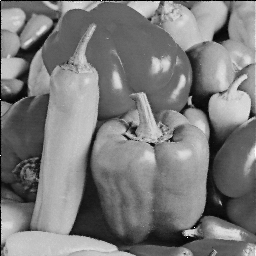

In [ ]:
corrected_img